In [1]:
!pip3 install jiwer
!pip3 install jieba
!pip install opencc-python-reimplemented
!pip install cn2an

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import jiwer
import jieba
import re
import opencc
import matplotlib.pyplot as plt
import cn2an
import seaborn as sns
from scipy import stats

## Construct dataframe


In [13]:
df_A_cleaned = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-wav2vec/data/D00XX_A.csv', index_col=0, skipinitialspace=True)
df_B_cleaned = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-wav2vec/data/D00XX_B.csv', index_col=0, skipinitialspace=True)
df_P_cleaned = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-wav2vec/data/P00XX.csv', index_col=0, skipinitialspace=True)
df_A_cleaned['file'] = df_A_cleaned['file'].str.extract(r'/(D\d{4}_A)', expand=False)
df_B_cleaned['file'] = df_B_cleaned['file'].str.extract(r'/(D\d{4}_B)', expand=False)
df_P_cleaned['file'] = df_P_cleaned['file'].str.extract(r'/(P\d{4})', expand=False)

df_cleaned = pd.concat([df_A_cleaned, df_B_cleaned, df_P_cleaned])
print(len(df_cleaned))
df_cleaned['start_time'] = df_cleaned['start_time'].astype(float)
df_cleaned['end_time'] = df_cleaned['end_time'].astype(float)
df_cleaned = df_cleaned.drop(columns=['participant'])
df_cleaned = df_cleaned.drop_duplicates()

df_cleaned = df_cleaned.assign(ground_truth_cleaned=df_cleaned['ground_truth_cleaned'].apply(lambda x: re.sub(r"[，。]", "", x)))
df_cleaned = df_cleaned.assign(ground_truth_cleaned=df_cleaned['ground_truth_cleaned'].apply(lambda x: re.sub(r"<.*?>", "", x)))
    
df_model = pd.read_csv(f'/projectnb/ds549/projects/AImpower/datasets/generated-transcripts/Whisper_large.csv', index_col=0, skipinitialspace=True)
df_model = df_model.rename(columns={'Filename': 'file', 'Start_time': 'start_time', 'End_time': 'end_time'})
df_model['start_time'] = df_model['start_time'].astype(float)
df_model['end_time'] = df_model['end_time'].astype(float)
df_model = df_model.drop_duplicates()

df_merged = pd.merge(df_cleaned, df_model, on=['file', 'start_time', 'end_time'], how='outer')

df_merged = df_merged[df_merged['ground_truth_cleaned'].apply(lambda x: isinstance(x, str))]
df_merged = df_merged[df_merged['Whisper_large'].apply(lambda x: isinstance(x, str))]
# ground_truth_cleaned == ""    10+ pieces
df_merged = df_merged[df_merged['ground_truth_cleaned']!=""]
print(len(df_merged))

37250
37202


In [14]:
#ground_truth include English
# df_merged = df_merged.assign(include_english = df_merged['ground_truth_cleaned'].apply(lambda x: bool(re.search(r'\b[a-zA-Z]+\b', x))))
# data_english = df_merged[df_merged['include_english']==True]
# data_english.to_csv('english.csv')

In [15]:
#clean data for predicted transcription
#transfer from traditional to simple
converter = opencc.OpenCC('t2s')  
df_merged = df_merged.assign(Whisper_large=df_merged['Whisper_large'].apply(lambda x: converter.convert(x)))
#clean puactuation and transfer numbers
pattern  = r"[\s\W]"
df_merged = df_merged.assign(Whisper_large = df_merged['Whisper_large'].apply(lambda x: re.sub(pattern, "", x)))
df_merged = df_merged.assign(Whisper_large = df_merged['Whisper_large'].apply(lambda x: cn2an.transform(x, "an2cn")))

In [16]:
#ground_truth_cleaned_with_repetition 
mask_pattern = r"\<.*?\>"
annotation_pattern = r"/\w"

df_merged = df_merged.assign(ground_truth_cleaned_with_repetition=df_merged['ground_truth'].apply(lambda x: re.sub(mask_pattern, "", x)))
df_merged = df_merged.assign(ground_truth_cleaned_with_repetition=df_merged['ground_truth_cleaned_with_repetition'].apply(lambda x: re.sub(annotation_pattern, "", x)))

#transfer from traditional to simple
df_merged = df_merged.assign(ground_truth_cleaned_with_repetition=df_merged['ground_truth_cleaned_with_repetition'].apply(lambda x: converter.convert(x)))
#clean puactuation and transfer numbers
pattern  = r"[\s\W]"
df_merged = df_merged.assign(ground_truth_cleaned_with_repetition = df_merged['ground_truth_cleaned_with_repetition'].apply(lambda x: re.sub(pattern, "", x)))
df_merged = df_merged.assign(ground_truth_cleaned_with_repetition = df_merged['ground_truth_cleaned_with_repetition'].apply(lambda x: cn2an.transform(x, "an2cn")))

In [17]:
df_merged

,file,start_time,end_time,ground_truth,ground_truth_cleaned,Whisper_large,ground_truth_cleaned_with_repetition
0,D0001_A,87.970,94.850,大/r[大]家好，我是叫<姓名>，那。,大家好我是叫那,大家好我是玛那,大大家好我是叫那
1,D0001_A,95.580,102.830,我是，今年是，<年龄>岁来自<居住地>，呃/i。,我是今年是岁来自,我是今年是来自,我是今年是岁来自呃
2,D0001_A,104.090,105.680,我是。,我是,我是,我是
3,D0001_A,106.300,119.120,资深/p的口/b[口/r/b]吃患者。,资深的口吃患者,名之身的口口吃患者,资深的口口吃患者
4,D0001_A,119.130,124.490,我是从小就有口吃。,我是从小就有口吃,我是从小就有口吃,我是从小就有口吃
...,...,...,...,...,...,...,...
37245,P0070,3032.636,3035.926,你好，米雅，拿日元换法郎怎么换。,你好米雅拿日元换法郎怎么换,你好米娅拿日元换法郎怎换,你好米雅拿日元换法郎怎么换
37246,P0070,3037.766,3041.436,你好，米雅，六百五十韩元是多少法郎。,你好米雅六百五十韩元是多少法郎,你好米娅六百五十韩元是多少法郎,你好米雅六百五十韩元是多少法郎
37247,P0070,3043.086,3045.546,你好，米雅，添加日程。,你好米雅添加日程,你好米亚天加日成,你好米雅添加日程
37248,P0070,3049.256,3053.116,我觉得推翻现有数学体系不是那么不可思议了。,我觉得推翻现有数学体系不是那么不可思议了,我觉得推翻现有数学体系不是那么不可思议了,我觉得推翻现有数学体系不是那么不可思议了


In [18]:
# df_merged_a = df_merged[df_merged['Whisper_large'].apply(lambda x: isinstance(x, float))]
# df_merged_a
# df_merged_b = df_merged[df_merged['ground_truth_cleaned'].apply(lambda x: isinstance(x, float))]
# df_merged_b

In [19]:
#without repetition
#word/character error rate
WER = []
CER = []
#word/character error count
# WEC = []
# CEC = []

for i in range(df_merged.shape[0]):
    reference = df_merged['ground_truth_cleaned'].iloc[i]
    hypothesis = df_merged['Whisper_large'].iloc[i]
    if not isinstance(reference, str) or not isinstance(hypothesis, str):
        WER.append(np.nan)
        CER.append(np.nan)
    else:
#         print(' '.join(jieba.lcut(reference)),"COMPARE", ' '.join(jieba.lcut(hypothesis)))
#         print(jiwer.wer(' '.join(jieba.lcut(reference)), ' '.join(jieba.lcut(hypothesis))))
#         print(jiwer.cer(reference, hypothesis))
        WER.append(jiwer.wer(' '.join(jieba.lcut(reference)), ' '.join(jieba.lcut(hypothesis))))
        CER.append(jiwer.cer(reference, hypothesis))

df_merged['WER'] = WER
df_merged['CER'] = CER

#with repetition
#word/character error rate
WER = []
CER = []
#word/character error count
# WEC = []
# CEC = []

for i in range(df_merged.shape[0]):
    reference = df_merged['ground_truth_cleaned_with_repetition'].iloc[i]
    hypothesis = df_merged['Whisper_large'].iloc[i]
    if not isinstance(reference, str) or not isinstance(hypothesis, str):
        WER.append(np.nan)
        CER.append(np.nan)
    else:
#         print(' '.join(jieba.lcut(reference)),"COMPARE", ' '.join(jieba.lcut(hypothesis)))
#         print(jiwer.wer(' '.join(jieba.lcut(reference)), ' '.join(jieba.lcut(hypothesis))))
#         print(jiwer.cer(reference, hypothesis))
        WER.append(jiwer.wer(' '.join(jieba.lcut(reference)), ' '.join(jieba.lcut(hypothesis))))
        CER.append(jiwer.cer(reference, hypothesis))

df_merged['WER_repetition'] = WER
df_merged['CER_repetition'] = CER

Building prefix dict from the default dictionary ...
Dumping model to file cache /scratch/1445963.1.cds-gpu/jieba.cache
Loading model cost 0.553 seconds.
Prefix dict has been built successfully.


In [20]:
repetition_pattern = r"\[.*?\]"
annotation_pattern = r"/\w"

df_merged['duration'] = df_merged['end_time']-df_merged['start_time']
df_merged = df_merged.assign(stutterance_count=df_merged['ground_truth'].apply(lambda x: len(re.findall(repetition_pattern, x)) + len(re.findall(annotation_pattern, x))))
df_merged = df_merged.assign(character_count=df_merged['ground_truth_cleaned'].apply(lambda x: len(x)))
df_merged = df_merged.assign(character_count_repetition=df_merged['ground_truth_cleaned_with_repetition'].apply(lambda x: len(x)))
df_merged['stutterance_frequency'] = df_merged['stutterance_count']/df_merged['character_count']
df_merged['stutterance_frequency_time'] = df_merged['stutterance_count']/df_merged['duration']

In [32]:
df_merged = df_merged.assign(word=df_merged['ground_truth'].apply(lambda x: len(re.findall(repetition_pattern, x))))
df_merged = df_merged.assign(r=df_merged['ground_truth'].apply(lambda x: x.count("/r")))
df_merged = df_merged.assign(i=df_merged['ground_truth'].apply(lambda x: x.count("/i")))
df_merged = df_merged.assign(p=df_merged['ground_truth'].apply(lambda x: x.count("/p")))
df_merged = df_merged.assign(b=df_merged['ground_truth'].apply(lambda x: x.count("/b")))

In [33]:
#delete data with mask
# df_merged = df_merged.assign(mask = df_merged['ground_truth'].apply(lambda x: bool(re.search(r'<[^<>]*[\u4e00-\u9fff]+[^<>]*>', x))))
# df_merged = df_merged[df_merged['mask']==False]
# df_merged = df_merged.drop('mask', axis=1)

In [36]:
df_merged.loc[96]

file                                                                              D0001_A
start_time                                                                    1658.334734
end_time                                                                          1678.34
ground_truth                            那/b把剑就[就]被嗯/i男二号抢了，他/p这个反派也就到最后的时候，反派他[他]都会成/r...
ground_truth_cleaned                             那把剑就被男二号抢了他这个反派也就到最后的时候反派他都会成功但是呢就突然出现一个
Whisper_large                                       那把箭就被男二号抢了这个反派到最后的时候反派他都会成功但是呢就突然出现一个
ground_truth_cleaned_with_repetition         那把剑就就被嗯男二号抢了他这个反派也就到最后的时候反派他他都会成功但是呢嗯就突然出现一个
WER                                                                              0.137931
CER                                                                                   0.1
WER_repetition                                                                   0.242424
CER_repetition                                                                   0.181818
duration  

In [37]:
df_merged.to_csv('Whisper_large_evaluation.csv')

## Analysis

In [38]:
data = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-wav2vec/Whisper_large_evaluation.csv', index_col=0)

In [28]:
data.describe()

,start_time,end_time,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration
count,37202.000000,37202.000000,37202.000000,37202.000000,37202.000000,37202.000000,37202.000000,37202.000000,37202.000000,37202.000000,37202.000000
mean,1974.723674,1979.482558,0.303410,0.199363,0.305933,0.203320,1.010053,14.872238,15.682813,0.070966,4.758884
std,1026.391961,1024.583690,0.455199,0.343015,0.403099,0.299322,1.703391,13.683941,14.459909,0.161997,3.753245
min,0.490000,0.840000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.220000
25%,1124.042500,1132.190000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,0.000000,1.910000
50%,2107.215500,2110.158000,0.146700,0.095238,0.181818,0.111111,0.000000,10.000000,10.000000,0.000000,3.340000
75%,2769.481000,2772.629000,0.428571,0.250000,0.454545,0.272727,1.000000,20.000000,22.000000,0.083333,6.803063
max,4157.869000,4168.639000,18.666667,20.000000,16.000000,20.000000,17.000000,118.000000,126.000000,5.000000,32.330000


### Overall Analysis 

In [31]:
#find outliers manually
data[data['WER']>3]
data[data['CER']>3]
# data = data[data['Whisper_large'].str.contains('转发打赏')!=True]
# data = data[data['Whisper_large'].str.contains('中文字幕')!=True]
#deleted mask data
#mask 在structure里删除了
#8535	D0062_A	39.210	42.990 mask需手动删除
#786	D0006_A	1571.400000	1571.920 无特殊问题
#21617	P0019	2929.924000	2930.744 无特殊问题
#6648	D0048_A	1387.060	1387.950 音频有一些截断问题？不算
#8032	D0057_A	1735.290	1736.820 无特殊问题

,file,start_time,end_time,ground_truth,ground_truth_cleaned,Whisper_large,ground_truth_cleaned_with_repetition,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration
786,D0006_A,1571.400,1571.920,就。,就,中文字幕志愿者杨栋梁,就,4.000000,10.000000,4.000000,10.000000,0,1,1,0.000000,0.52
1216,D0010_A,1505.880,1507.720,<overlap>对[对对对]。,对,非常好嘟嘟嘟嘟,对对对对,4.000000,7.000000,1.000000,1.750000,1,1,4,1.000000,1.84
1977,D0016_A,584.550,585.640,这样<overlap>。,这样,unknown,这样,1.000000,3.500000,1.000000,3.500000,0,2,2,0.000000,1.09
2712,D0022_A,1201.990,1205.470,对对对对对确实[确实]。,对对对对对确实,tweettweettweettweettweet트를energized,对对对对对确实确实,1.000000,5.142857,1.000000,4.000000,1,7,9,0.142857,3.48
3971,D0030_A,1602.190,1608.340,呃/i/r两/p百。,两百,丁丁丁丁啊丁丁丁丁丁丁丁丁,呃两百,7.000000,6.500000,3.500000,4.333333,3,2,3,1.500000,6.15
4432,D0033_A,712.390,714.600,哦，对我/p是在<居住地>。,哦对我是在,请不吝点赞订阅转发打赏支持明镜与点点栏目,哦对我是在,2.200000,4.000000,2.200000,4.000000,1,5,5,0.200000,2.21
5026,D0037_A,486.420,497.310,就是就或者是一个低/r[低低低低低/r低低低低]谷的时候，这个情况就会变差，对。,就是就或者是一个低谷的时候这个情况就会变差对,就是就或者是一个滴滴滴滴滴滴滴滴滴滴滴滴滴滴滴滴滴滴滴滴滴滴滴滴滴滴滴滴滴滴滴滴滴滴滴滴滴滴...,就是就或者是一个低低低低低低低低低低谷的时候这个情况就会变差对,5.571429,4.863636,3.545455,3.451613,3,22,31,0.136364,10.89
5068,D0037_A,936.290,947.480,贵[贵贵贵/r贵贵贵贵贵贵/r贵/b/r贵贵/r/b贵]州啊等/r等的，嗯/i/p。,贵州啊等等的,滚滚混混混混混混混ogue滚滚滚混混混ц哗我就的呃,贵贵贵贵贵贵贵贵贵贵贵贵贵贵州啊等等的嗯,3.750000,4.000000,1.363636,1.200000,10,6,20,1.666667,11.19
5097,D0037_A,1269.050,1279.670,一个/p能[能能/r能能/r/b能能能能能能能能能]力和水[水水水水水]平了。,一个能力和水平了,一个难当难当能立鹅试试试试试试试试试试试试试试试试试试试试试试试试试试试试试试试试试试试试试...,一个能能能能能能能能能能能能能能力和水水水水水水平了,8.400000,10.125000,2.210526,3.115385,6,8,26,0.750000,10.62
5154,D0037_A,1841.830,1851.110,有[有]点逃[逃/r逃/r逃逃逃逃逃]避，社[社社社社社社社社社社]交。,有点逃避社交,有有点逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃逃...,有有点逃逃逃逃逃逃逃逃避社社社社社社社社社社社交,18.666667,9.166667,3.000000,1.958333,5,6,24,0.833333,9.28


In [32]:
data = data.assign(z_scores = data['CER'].apply(lambda x: (x-data['CER'].mean())/data['CER'].std()))
data_normal = data[data['z_scores']<3]
data_normal = data_normal.assign(z_scores = data_normal['WER'].apply(lambda x: (x-data_normal['WER'].mean())/data_normal['WER'].std()))
data_normal = data_normal[data_normal['z_scores']<3]
data_normal = data_normal.assign(z_scores = data_normal['WER_repetition'].apply(lambda x: (x-data_normal['WER_repetition'].mean())/data_normal['WER_repetition'].std()))
data_normal = data_normal[data_normal['z_scores']<3]
data_normal = data_normal.assign(z_scores = data_normal['CER_repetition'].apply(lambda x: (x-data_normal['CER_repetition'].mean())/data_normal['CER_repetition'].std()))
data_normal = data_normal[data_normal['z_scores']<3]
data_outliers = data[~data.index.isin(data_normal.index)]
data.drop('z_scores', axis=1)
data_outliers

,file,start_time,end_time,ground_truth,ground_truth_cleaned,Whisper_large,ground_truth_cleaned_with_repetition,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration,z_scores
8,D0001_A,150.850,154.010,那我是。,那我是,这样过evet,那我是,1.000000,2.333333,1.000000,2.333333,0,3,3,0.0,3.16,6.221213
89,D0001_A,1542.170,1542.910,优。,优,有,优,1.000000,1.000000,1.000000,1.000000,0,1,1,0.0,0.74,2.334115
216,D0002_A,1572.650,1573.490,是吗哈。,是吗哈,什么,是吗哈,1.000000,1.000000,1.000000,1.000000,0,3,3,0.0,0.84,2.334115
281,D0003_A,522.980,523.850,呃。,呃,嗯,呃,1.000000,1.000000,1.000000,1.000000,0,1,1,0.0,0.87,2.334115
323,D0003_A,978.590,980.600,<overlap>哦这样子啊。,哦这样子啊,但是,哦这样子啊,1.000000,1.000000,1.000000,1.000000,0,5,5,0.0,2.01,2.334115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37050,P0070,2213.576,2214.586,热菜。,热菜,乐采,热菜,1.000000,1.000000,1.000000,1.000000,0,2,2,0.0,1.01,2.334115
37158,P0070,2665.636,2667.606,亮剑收视率咋样。,亮剑收视率咋样,这样见收市率咋样,亮剑收视率咋样,1.333333,0.571429,1.333333,0.571429,0,7,7,0.0,1.97,1.084691
37163,P0070,2685.886,2687.046,霸王别姬。,霸王别姬,霸王劣迹,霸王别姬,2.000000,0.500000,2.000000,0.500000,0,4,4,0.0,1.16,0.876453
37181,P0070,2751.986,2754.426,大话西游之月光宝盒。,大话西游之月光宝盒,大化稀油脂月光饱和,大话西游之月光宝盒,1.666667,0.666667,1.666667,0.666667,0,9,9,0.0,2.44,1.362340


In [33]:
data_outliers.to_csv('outliers.csv')

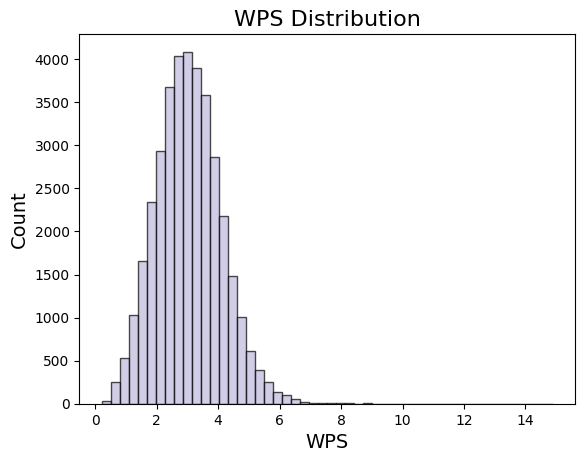

In [41]:
#speed
data['WPS'] = data['character_count']/data['duration']
plt.hist(data['WPS'], bins = 50, color='#BEB8DC', edgecolor='black', alpha=0.7)
plt.title("WPS Distribution", fontsize=16)
plt.xlabel("WPS", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

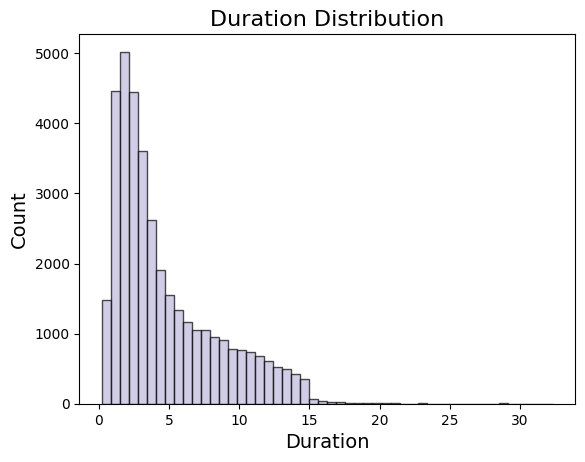

In [37]:
#duration
plt.hist(data['duration'], bins = 50, color='#BEB8DC', edgecolor='black', alpha=0.7)
plt.title("Duration Distribution", fontsize=16)
plt.xlabel("Duration", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

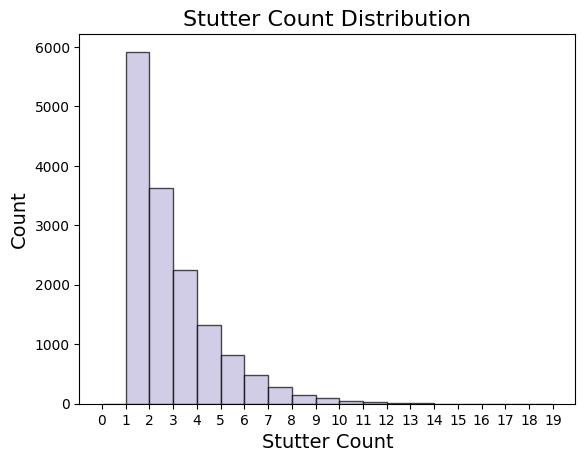

In [52]:
#stutter_count
plt.hist(data_stutter['stutterance_count'],np.arange(0,20,1), color='#BEB8DC', edgecolor='black', alpha=0.7)
plt.xticks(ticks=np.arange(0, 20, 1))
plt.title("Stutter Count Distribution", fontsize=16)
plt.xlabel("Stutter Count", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

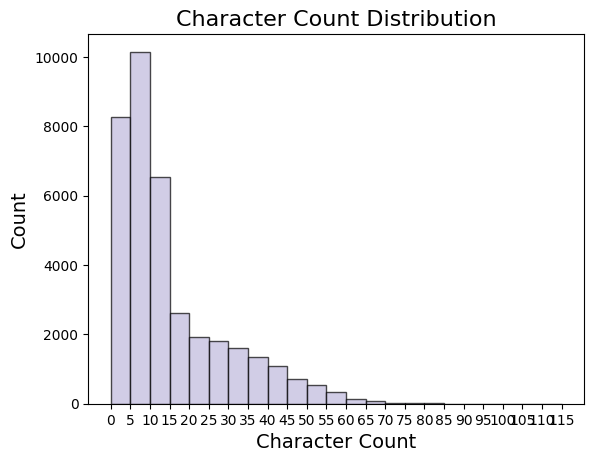

In [66]:
#character_count
plt.hist(data['character_count'],np.arange(0,120,5), color='#BEB8DC', edgecolor='black', alpha=0.7)
plt.xticks(ticks=np.arange(0, 120, 5))
plt.title("Character Count Distribution", fontsize=16)
plt.xlabel("Character Count", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

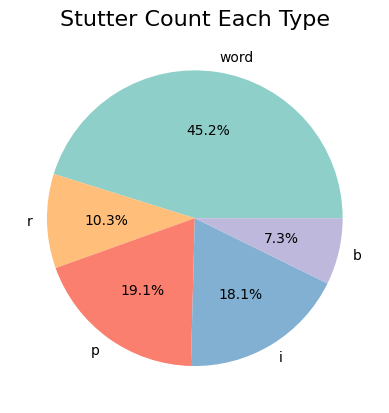

In [67]:
word_sum = data['word'].sum()
i = data['i'].sum()
p = data['p'].sum()
r = data['r'].sum()
b = data['b'].sum()
custom_colors = ['#8ecfc9', '#ffbe7a', '#fa7f6f', '#82b0d2', '#beb8dc']
plt.pie([word_sum,r,p,i,b], labels = ['word', 'r', 'p', 'i', 'b'], autopct='%1.1f%%', colors = custom_colors)
plt.title("Stutter Count Each Type", fontsize=16)
plt.show()

In [43]:
#correlation
data_number = data[['WER','CER','WER_repetition','CER_repetition','stutterance_count','character_count','character_count_repetition','stutterance_frequency','duration', 'WPS']]
data_cor_spearman = data_number.corr(method="spearman")
data_cor_pearson = data_number.corr()

In [44]:
data_cor_pearson

,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration,WPS
WER,1.000000,0.801277,0.835888,0.699402,-0.017617,-0.237823,-0.221841,0.217478,-0.182830,-0.145861
CER,0.801277,1.000000,0.685966,0.901690,0.007417,-0.200733,-0.183000,0.224629,-0.151783,-0.130551
WER_repetition,0.835888,0.685966,1.000000,0.763980,-0.005561,-0.221340,-0.209185,0.140780,-0.177321,-0.115343
CER_repetition,0.699402,0.901690,0.763980,1.000000,0.030902,-0.197568,-0.178736,0.172595,-0.147214,-0.127007
stutterance_count,-0.017617,0.007417,-0.005561,0.030902,1.000000,0.468071,0.540177,0.610758,0.678776,-0.164123
character_count,-0.237823,-0.200733,-0.221340,-0.197568,0.468071,1.000000,0.993345,-0.020470,0.894572,0.426392
character_count_repetition,-0.221841,-0.183000,-0.209185,-0.178736,0.540177,0.993345,1.000000,0.039115,0.913173,0.386797
stutterance_frequency,0.217478,0.224629,0.140780,0.172595,0.610758,-0.020470,0.039115,1.000000,0.196809,-0.406147
duration,-0.182830,-0.151783,-0.177321,-0.147214,0.678776,0.894572,0.913173,0.196809,1.000000,0.087254
WPS,-0.145861,-0.130551,-0.115343,-0.127007,-0.164123,0.426392,0.386797,-0.406147,0.087254,1.000000


In [45]:
data_cor_spearman

,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration,WPS
WER,1.000000,0.970179,0.876070,0.840275,0.012230,-0.063765,-0.051381,0.047499,-0.037915,-0.034815
CER,0.970179,1.000000,0.851108,0.871898,0.043790,-0.042241,-0.027555,0.072726,-0.018547,-0.022653
WER_repetition,0.876070,0.851108,1.000000,0.963315,0.123944,-0.065079,-0.033838,0.176762,-0.005857,-0.106070
CER_repetition,0.840275,0.871898,0.963315,1.000000,0.168849,-0.038400,-0.002893,0.215103,0.021832,-0.097499
stutterance_count,0.012230,0.043790,0.123944,0.168849,1.000000,0.533607,0.601933,0.954390,0.691973,-0.112865
character_count,-0.063765,-0.042241,-0.065079,-0.038400,0.533607,1.000000,0.990239,0.370236,0.903995,0.483997
character_count_repetition,-0.051381,-0.027555,-0.033838,-0.002893,0.601933,0.990239,1.000000,0.450263,0.927480,0.432262
stutterance_frequency,0.047499,0.072726,0.176762,0.215103,0.954390,0.370236,0.450263,1.000000,0.568896,-0.239642
duration,-0.037915,-0.018547,-0.005857,0.021832,0.691973,0.903995,0.927480,0.568896,1.000000,0.108741
WPS,-0.034815,-0.022653,-0.106070,-0.097499,-0.112865,0.483997,0.432262,-0.239642,0.108741,1.000000


### Stutter VS non-Stutter

In [51]:
data_stutter = data[data['stutterance_count']>0]
data_non_stutter = data[data['stutterance_count']==0]

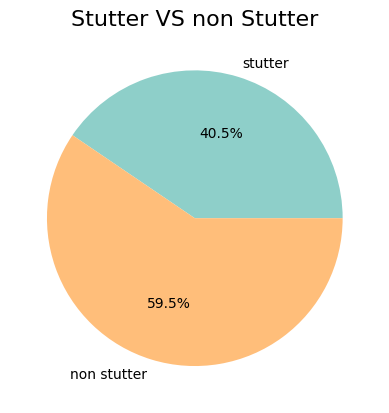

In [68]:
custom_colors = ['#8ecfc9', '#ffbe7a']
plt.pie([len(data_stutter), len(data_non_stutter)], labels = ['stutter', 'non stutter'], autopct='%1.1f%%', colors = custom_colors)
plt.title("Stutter VS non Stutter", fontsize=16)
plt.show()

In [47]:
data_stutter.describe()

,start_time,end_time,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration,z_scores,speed,WPS
count,15072.000000,15072.000000,15072.000000,15072.000000,15072.000000,15072.000000,15072.000000,15072.000000,15072.000000,15072.000000,15072.000000,15072.000000,15072.000000,15072.000000
mean,1453.563510,1461.208256,0.276343,0.188493,0.289375,0.202670,2.493100,23.249668,25.322718,0.175165,7.644746,-0.031690,2.896661,2.896661
std,974.099645,972.695158,0.480619,0.347939,0.339021,0.223941,1.861313,15.472925,15.994662,0.215695,3.824754,1.014355,1.077709,1.077709
min,0.490000,6.210000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.011628,0.480000,-0.581208,0.216920,0.216920
25%,642.605000,652.672500,0.043478,0.027027,0.100000,0.064516,1.000000,10.000000,11.000000,0.062500,4.520000,-0.502416,2.081561,2.081561
50%,1296.980000,1306.455000,0.142857,0.096774,0.200000,0.142857,2.000000,21.000000,23.000000,0.111111,7.320000,-0.299080,2.928541,2.928541
75%,2175.376250,2180.765250,0.333333,0.216510,0.388889,0.266667,3.000000,34.000000,37.000000,0.200000,10.490000,0.049988,3.676471,3.676471
max,4157.869000,4168.639000,18.666667,10.125000,16.000000,4.333333,17.000000,118.000000,126.000000,5.000000,32.330000,28.936440,7.976366,7.976366


In [48]:
data_non_stutter.describe()

,start_time,end_time,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration,z_scores,speed,WPS
count,22130.000000,22130.000000,22130.000000,22130.000000,22130.000000,22130.000000,22130.0,22130.000000,22130.000000,22130.0,22130.000000,22130.000000,22130.000000,22130.000000
mean,2329.668364,2332.461784,0.321844,0.206767,0.317210,0.203764,0.0,9.166652,9.117397,0.0,2.793420,0.021583,3.158288,3.158288
std,902.103281,901.583218,0.436091,0.339429,0.441100,0.341263,0.0,8.448592,8.418220,0.0,2.045211,0.989547,1.032397,1.032397
min,0.500000,0.840000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,0.0,0.220000,-0.581208,0.362319,0.362319
25%,1854.310000,1857.169000,0.000000,0.000000,0.000000,0.000000,0.0,4.000000,4.000000,0.0,1.480000,-0.581208,2.439024,2.439024
50%,2422.276000,2424.677000,0.166667,0.090909,0.142857,0.090909,0.0,7.000000,7.000000,0.0,2.280000,-0.316179,3.061224,3.061224
75%,2985.533500,2987.923000,0.500000,0.300000,0.500000,0.285714,0.0,11.000000,11.000000,0.0,3.380000,0.293389,3.768844,3.768844
max,4153.299000,4157.799000,11.000000,20.000000,11.000000,20.000000,0.0,79.000000,79.000000,0.0,20.070000,57.725258,14.893617,14.893617


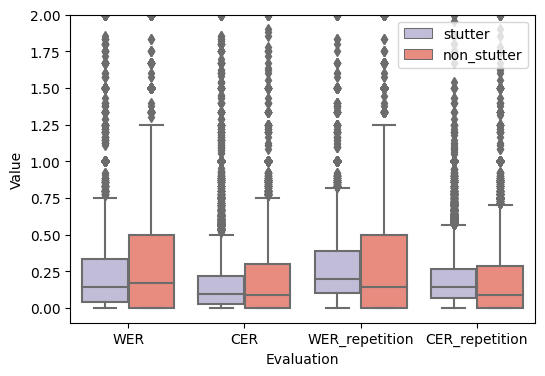

In [69]:
data_stutter_number = data_stutter[['WER','CER','WER_repetition','CER_repetition']].melt(var_name='Evaluation', value_name='Value')
data_stutter_number['Group'] = 'stutter'
data_non_stutter_number = data_non_stutter[['WER','CER','WER_repetition','CER_repetition']].melt(var_name='Evaluation', value_name='Value')
data_non_stutter_number['Group'] = 'non_stutter'
combined_data = pd.concat([data_stutter_number, data_non_stutter_number])

fig,ax = plt.subplots(figsize=(6, 4))
custom_palette = ['#BEB8DC', '#FA7F6F']
sns.boxplot(data=combined_data, x='Evaluation', y='Value', hue='Group', palette=custom_palette, ax=ax)
ax.set_ylim(-0.1, 2) 
plt.title("")
plt.legend()
plt.show()

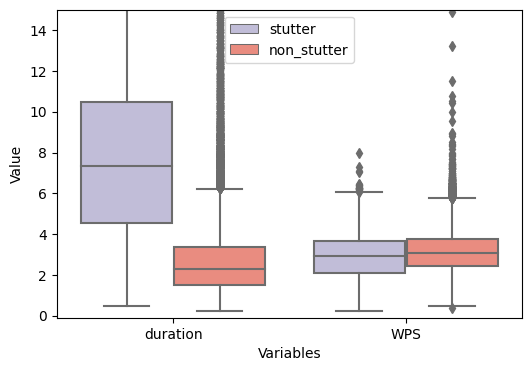

In [77]:
data_stutter_number = data_stutter[['duration', 'WPS']].melt(var_name='Variables', value_name='Value')
data_stutter_number['Group'] = 'stutter'
data_non_stutter_number = data_non_stutter[['duration', 'WPS']].melt(var_name='Variables', value_name='Value')
data_non_stutter_number['Group'] = 'non_stutter'
combined_data = pd.concat([data_stutter_number, data_non_stutter_number])

fig,ax = plt.subplots(figsize=(6, 4))
custom_palette = ['#BEB8DC', '#FA7F6F']
sns.boxplot(data=combined_data, x='Variables', y='Value', hue='Group', palette=custom_palette, ax=ax)
ax.set_ylim(-0.1, 15) 
plt.title("")
plt.legend()
plt.show()

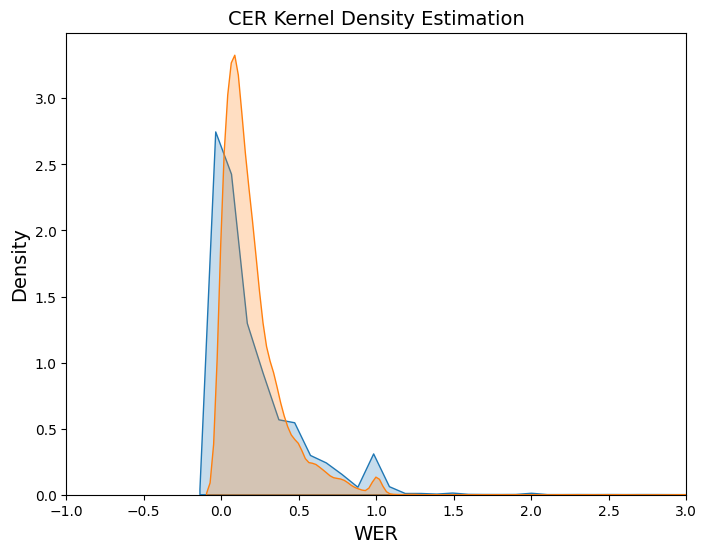

In [78]:
#CER
plt.figure(figsize=(8, 6))
sns.kdeplot(data_non_stutter['CER'], label='non_stutter', fill=True)
sns.kdeplot(data_stutter['CER_repetition'], label='stutter', fill=True)

plt.title("CER Kernel Density Estimation", fontsize=14)
plt.xlim(-1,3)
plt.xlabel('WER', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()

### non-Stutter

In [82]:
#non-stutter data
data_non_stutter_number = data_non_stutter[['WER','CER','WER_repetition','CER_repetition','character_count','character_count_repetition','duration', 'WPS']]
data_non_stutter_cor_pearson = data_non_stutter_number.corr()
data_non_stutter_cor_spearman = data_non_stutter_number.corr(method = 'spearman')

In [83]:
data_non_stutter_cor_pearson

,WER,CER,WER_repetition,CER_repetition,character_count,character_count_repetition,duration,WPS
WER,1.000000,0.774943,0.989092,0.768337,-0.171028,-0.173881,-0.175505,-0.005587
CER,0.774943,1.000000,0.773250,0.997484,-0.155920,-0.158403,-0.170819,-0.005359
WER_repetition,0.989092,0.773250,1.000000,0.772829,-0.171887,-0.173197,-0.176000,-0.005022
CER_repetition,0.768337,0.997484,0.772829,1.000000,-0.157606,-0.158778,-0.171065,-0.011861
character_count,-0.171028,-0.155920,-0.171887,-0.157606,1.000000,0.999525,0.915622,0.456842
character_count_repetition,-0.173881,-0.158403,-0.173197,-0.158778,0.999525,1.000000,0.916226,0.452486
duration,-0.175505,-0.170819,-0.176000,-0.171065,0.915622,0.916226,1.000000,0.163034
WPS,-0.005587,-0.005359,-0.005022,-0.011861,0.456842,0.452486,0.163034,1.000000


In [84]:
data_non_stutter_cor_spearman

,WER,CER,WER_repetition,CER_repetition,character_count,character_count_repetition,duration,WPS
WER,1.000000,0.967206,0.984962,0.953652,0.023759,0.016801,-0.010591,0.071579
CER,0.967206,1.000000,0.958449,0.989697,0.022753,0.016265,-0.018283,0.083453
WER_repetition,0.984962,0.958449,1.000000,0.968993,0.022335,0.020536,-0.007041,0.062317
CER_repetition,0.953652,0.989697,0.968993,1.000000,0.019522,0.017563,-0.016329,0.073117
character_count,0.023759,0.022753,0.022335,0.019522,1.000000,0.998898,0.890721,0.553322
character_count_repetition,0.016801,0.016265,0.020536,0.017563,0.998898,1.000000,0.892401,0.548842
duration,-0.010591,-0.018283,-0.007041,-0.016329,0.890721,0.892401,1.000000,0.160322
WPS,0.071579,0.083453,0.062317,0.073117,0.553322,0.548842,0.160322,1.000000


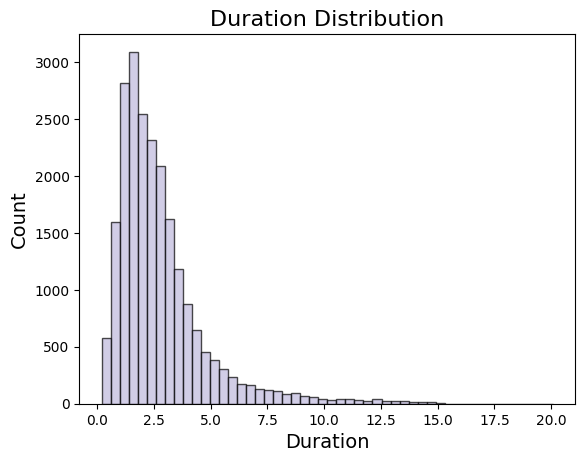

count    22130.000000
mean         2.793420
std          2.045211
min          0.220000
25%          1.480000
50%          2.280000
75%          3.380000
max         20.070000
Name: duration, dtype: float64

In [25]:
#duration
plt.hist(data_non_stutter['duration'], bins = 50, color='#BEB8DC', edgecolor='black', alpha=0.7)
plt.title("Duration Distribution", fontsize=16)
plt.xlabel("Duration", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

data_non_stutter['duration'].describe()

In [30]:
data_non_stutter_long = data_non_stutter[data_non_stutter['duration'] > 7.5]
data_non_stutter_medium = data_non_stutter[data_non_stutter['duration'] > 3.38]
data_non_stutter_medium = data_non_stutter_medium[data_non_stutter_medium['duration'] <= 7.5]
data_non_stutter_short = data_non_stutter[data_non_stutter['duration']<=3.38]

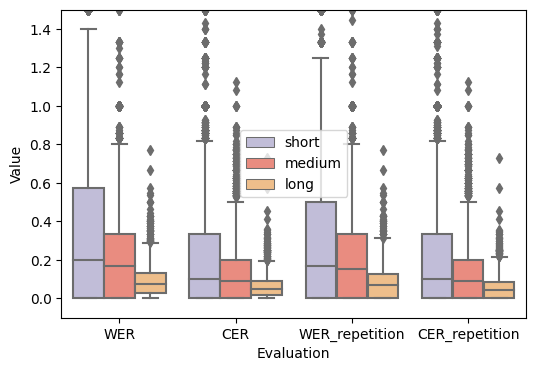

In [39]:
data_non_stutter_long_number = data_non_stutter_long[['WER','CER','WER_repetition','CER_repetition']].melt(var_name='Evaluation', value_name='Value')
data_non_stutter_long_number['Group'] = 'long'
data_non_stutter_medium_number = data_non_stutter_medium[['WER','CER','WER_repetition','CER_repetition']].melt(var_name='Evaluation', value_name='Value')
data_non_stutter_medium_number['Group'] = 'medium'
data_non_stutter_short_number = data_non_stutter_short[['WER','CER','WER_repetition','CER_repetition']].melt(var_name='Evaluation', value_name='Value')
data_non_stutter_short_number['Group'] = 'short'
combined_data = pd.concat([data_non_stutter_short_number,data_non_stutter_medium_number, data_non_stutter_long_number])

fig,ax = plt.subplots(figsize=(6, 4))
custom_palette = ['#BEB8DC', '#FA7F6F', "#FFBE7A"]
sns.boxplot(data=combined_data, x='Evaluation', y='Value', hue='Group', palette=custom_palette, ax=ax)
ax.set_ylim(-0.1, 1.5) 
plt.title("")
plt.legend()
plt.show()

### Stutter

In [43]:
data_stutter_number = data_stutter[['WER','CER','WER_repetition','CER_repetition','stutterance_count','character_count','character_count_repetition','stutterance_frequency','duration', 'WPS']]
data_stutter_cor_spearman = data_stutter_number.corr(method='spearman')
data_stutter_cor_pearson = data_stutter_number.corr()

In [87]:
data_stutter_cor_spearman

,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration,WPS
WER,1.000000,0.965872,0.612907,0.593384,0.032209,-0.252218,-0.228416,0.246612,-0.164276,-0.227278
CER,0.965872,1.000000,0.585244,0.614867,0.053401,-0.221786,-0.193690,0.234659,-0.140007,-0.199595
WER_repetition,0.612907,0.585244,1.000000,0.951848,0.097001,-0.444084,-0.395363,0.486077,-0.304331,-0.411737
CER_repetition,0.593384,0.614867,0.951848,1.000000,0.130549,-0.400037,-0.344672,0.468485,-0.265240,-0.376827
stutterance_count,0.032209,0.053401,0.097001,0.130549,1.000000,0.288980,0.363703,0.438368,0.508179,-0.105117
character_count,-0.252218,-0.221786,-0.444084,-0.400037,0.288980,1.000000,0.988728,-0.693595,0.860446,0.729765
character_count_repetition,-0.228416,-0.193690,-0.395363,-0.344672,0.363703,0.988728,1.000000,-0.629175,0.880534,0.690121
stutterance_frequency,0.246612,0.234659,0.486077,0.468485,0.438368,-0.693595,-0.629175,1.000000,-0.408760,-0.759424
duration,-0.164276,-0.140007,-0.304331,-0.265240,0.508179,0.860446,0.880534,-0.408760,1.000000,0.315331
WPS,-0.227278,-0.199595,-0.411737,-0.376827,-0.105117,0.729765,0.690121,-0.759424,0.315331,1.000000


In [88]:
data_stutter_cor_pearson

,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration,WPS
WER,1.000000,0.836590,0.604374,0.625269,0.037746,-0.316030,-0.289875,0.427588,-0.222966,-0.341556
CER,0.836590,1.000000,0.541099,0.755316,0.058366,-0.281611,-0.251518,0.435913,-0.191982,-0.312347
WER_repetition,0.604374,0.541099,1.000000,0.746818,0.050485,-0.350752,-0.331400,0.349982,-0.268948,-0.335249
CER_repetition,0.625269,0.755316,0.746818,1.000000,0.097197,-0.381264,-0.343183,0.430033,-0.268253,-0.386959
stutterance_count,0.037746,0.058366,0.050485,0.097197,1.000000,0.209851,0.295827,0.389097,0.493960,-0.170800
character_count,-0.316030,-0.281611,-0.350752,-0.381264,0.209851,1.000000,0.990030,-0.473281,0.836999,0.695053
character_count_repetition,-0.289875,-0.251518,-0.331400,-0.343183,0.295827,0.990030,1.000000,-0.423923,0.856547,0.659345
stutterance_frequency,0.427588,0.435913,0.349982,0.430033,0.389097,-0.473281,-0.423923,1.000000,-0.254751,-0.622446
duration,-0.222966,-0.191982,-0.268948,-0.268253,0.493960,0.836999,0.856547,-0.254751,1.000000,0.268198
WPS,-0.341556,-0.312347,-0.335249,-0.386959,-0.170800,0.695053,0.659345,-0.622446,0.268198,1.000000


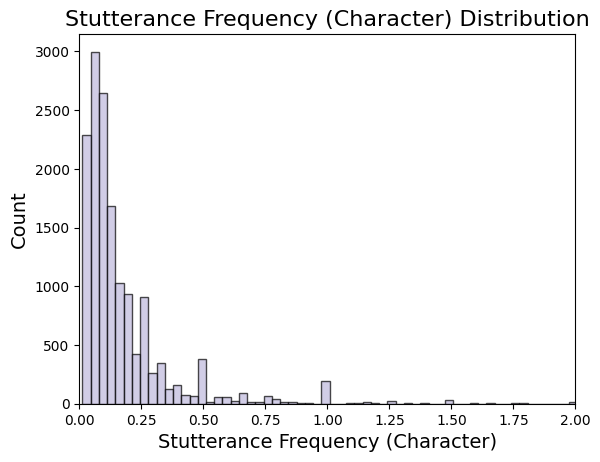

In [72]:
#stutterance frequency
plt.hist(data_stutter['stutterance_frequency'], bins = 150, color='#BEB8DC', edgecolor='black', alpha=0.7)
plt.title("Stutterance Frequency (Character) Distribution", fontsize=16)
plt.xlim(-0, 2)
plt.xlabel("Stutterance Frequency (Character)", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

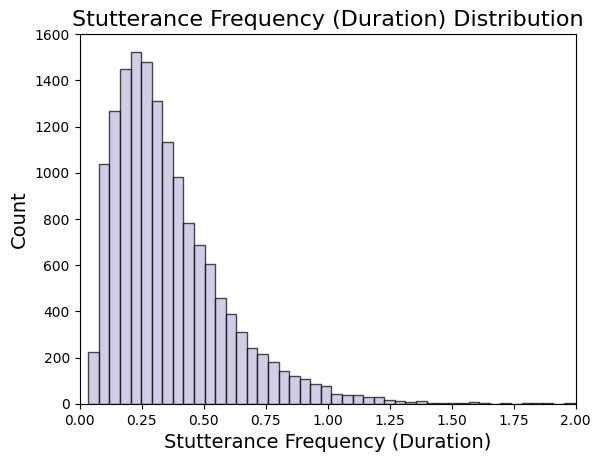

In [73]:
#stutterance frequency
plt.hist(data_stutter['stutterance_frequency_time'], bins = 50, color='#BEB8DC', edgecolor='black', alpha=0.7)
plt.title("Stutterance Frequency (Duration) Distribution", fontsize=16)
plt.xlim(-0, 2)
plt.xlabel("Stutterance Frequency (Duration)", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

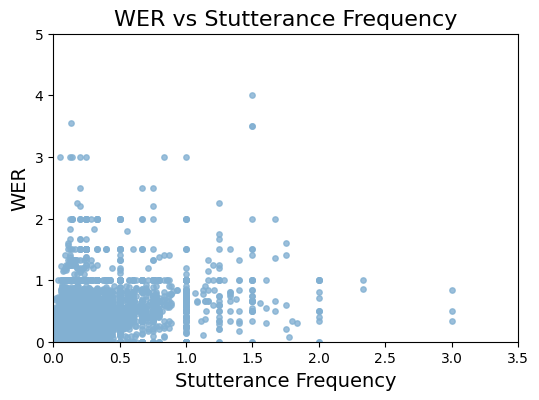

In [20]:
plt.figure(figsize=(6, 4))
plt.scatter(
    data_stutter["stutterance_frequency"], 
    data_stutter["WER_repetition"], 
    s=15,
    alpha=0.8,
    color="#82B0D2"
)
plt.xlim(0,3.5)
plt.ylim(0,5)

plt.title("WER vs Stutterance Frequency", fontsize=16)
plt.xlabel("Stutterance Frequency", fontsize=14)
plt.ylabel("WER", fontsize=14)
# plt.grid(True)
plt.show()

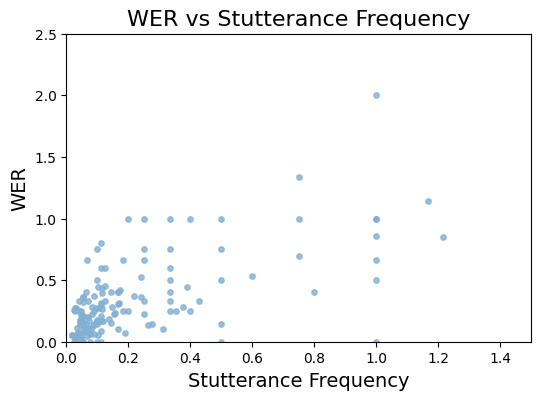

In [21]:
sampled_data_stutter = data_stutter.groupby('file').sample(frac=0.01, random_state=42)
plt.figure(figsize=(6, 4))
plt.scatter(
    sampled_data_stutter["stutterance_frequency"], 
    sampled_data_stutter["WER_repetition"], 
    s=15,
    alpha=0.8,
    color="#82B0D2"
)
plt.xlim(0,1.5)
plt.ylim(0,2.5)

plt.title("WER vs Stutterance Frequency", fontsize=16)
plt.xlabel("Stutterance Frequency", fontsize=14)
plt.ylabel("WER", fontsize=14)
# plt.grid(True)
plt.show()

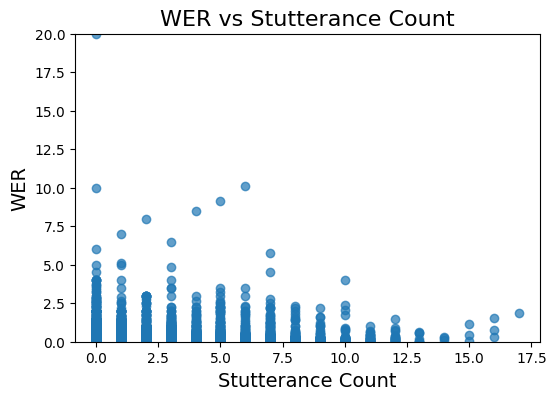

In [7]:
#stutterance count
plt.figure(figsize=(6, 4))
plt.scatter(
    data["stutterance_count"], 
    data["CER"], 
    alpha=0.7  # Handle overlapping points
)

plt.title("WER vs Stutterance Count", fontsize=16)
plt.ylim(0,20)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("WER", fontsize=14)
plt.show()

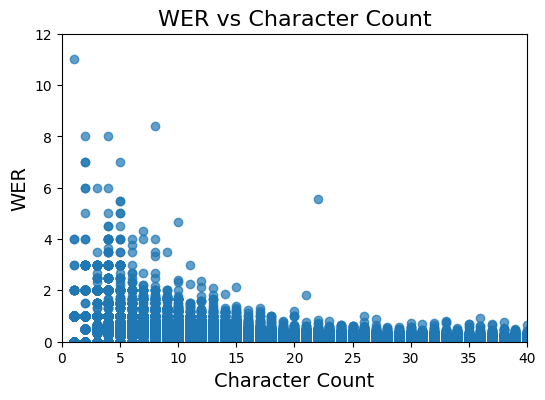

In [4]:
plt.figure(figsize=(6, 4))
plt.scatter(
    data["character_count"], 
    data["WER"], 
    alpha=0.7  # Handle overlapping points
)

plt.title("WER vs Character Count", fontsize=16)
plt.xlim(0,40)
plt.ylim(0,12)
plt.xlabel("Character Count", fontsize=14)
plt.ylabel("WER", fontsize=14)
plt.show()

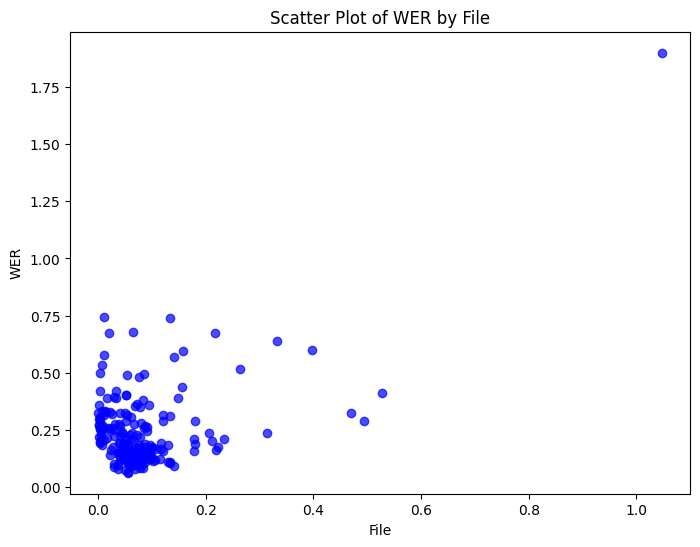

0.5120599386761514

In [156]:
plt.figure(figsize=(8, 6))
plt.scatter(grouped['stutterance_frequency'], wer_group['WER'], color='blue', alpha=0.7)
plt.title('Scatter Plot of WER by File')
plt.xlabel('File')
plt.ylabel('WER')
plt.show()

grouped['stutterance_frequency'].corr(wer_group['WER'])

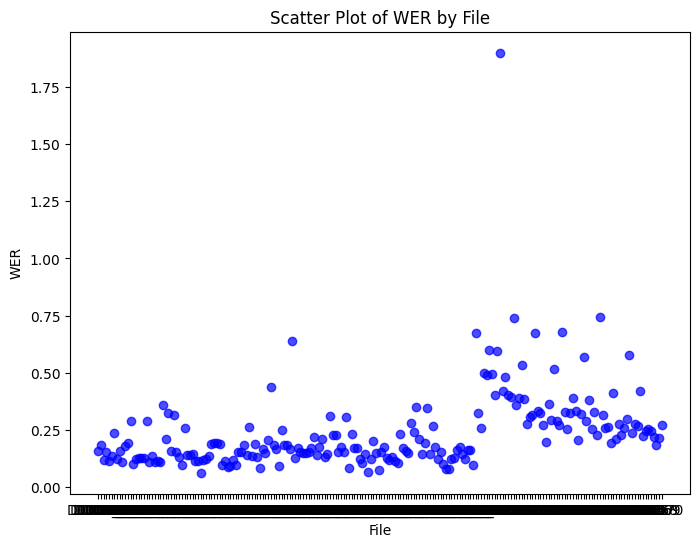

,file,WER
0,D0001_A,0.158873
1,D0001_B,0.182789
2,D0002_A,0.119123
3,D0002_B,0.153311
4,D0003_A,0.112837
...,...,...
205,P0066,0.245743
206,P0067,0.220192
207,P0068,0.183315
208,P0069,0.215463


In [147]:
wer_group = data.groupby('file')['WER'].mean().reset_index()
plt.figure(figsize=(8, 6))
plt.scatter(grouped['file'], grouped['WER'], color='blue', alpha=0.7)
plt.title('Scatter Plot of WER by File')
plt.xlabel('File')
plt.ylabel('WER')
plt.show()
wer_group

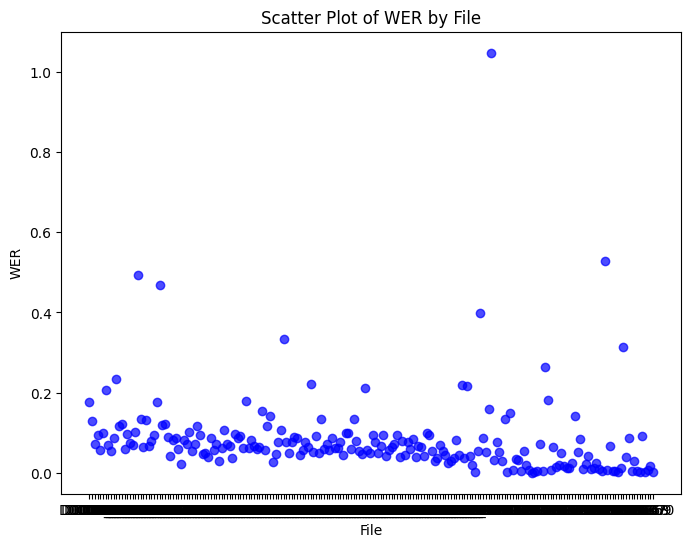

In [154]:
grouped = data.groupby('file')['stutterance_frequency'].mean().reset_index()
grouped
plt.figure(figsize=(8, 6))
plt.scatter(grouped['file'],grouped['stutterance_frequency'], color='blue', alpha=0.7)
plt.title('Scatter Plot of WER by File')
plt.xlabel('File')
plt.ylabel('WER')
plt.show()